# Time Series Transformer Model

In [1]:
pip install torch numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


## Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

# Load Reliance.csv
data = pd.read_csv('RELIANCE.csv', parse_dates=['Date'], index_col='Date')
# Use closing prices and compute returns for volatility
prices = data['Close']
returns = prices.pct_change().dropna()

## Data Preparation

In [3]:
import numpy as np
import pandas as pd
import torch

# Synthetic time series
time = np.arange(0, 400, 0.1)
series = np.sin(0.02 * time) + 0.5 * np.random.randn(len(time))

# Create input-output sequences
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

seq_len = 20
X, y = create_sequences(series, seq_len)
X = torch.from_numpy(X).float().unsqueeze(-1)  # (batch, seq, 1)
y = torch.from_numpy(y).float().unsqueeze(-1)  # (batch, 1)


## Model Definition

In [4]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, d_model=64,
                 nhead=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.src_embedding = nn.Linear(feature_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        # src shape: (batch, seq_len, feature_size)
        x = self.src_embedding(src) + self.pos_encoder
        # Transformer expects (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x[-1, :, :]               # take last time step
        out = self.decoder(x)         # (batch, 1)
        return out

model = TimeSeriesTransformer()  


C:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Training Loop

In [5]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

dataset = TensorDataset(X, y)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss {total_loss/len(loader):.4f}")


Epoch 1, Loss 0.2927
Epoch 2, Loss 0.2793
Epoch 3, Loss 0.2745
Epoch 4, Loss 0.2760
Epoch 5, Loss 0.2689
Epoch 6, Loss 0.2704
Epoch 7, Loss 0.2736
Epoch 8, Loss 0.2715
Epoch 9, Loss 0.2671
Epoch 10, Loss 0.2696
Epoch 11, Loss 0.2699
Epoch 12, Loss 0.2712
Epoch 13, Loss 0.2710
Epoch 14, Loss 0.2659
Epoch 15, Loss 0.2684
Epoch 16, Loss 0.2640
Epoch 17, Loss 0.2670
Epoch 18, Loss 0.2660
Epoch 19, Loss 0.2659
Epoch 20, Loss 0.2628


## Evaluation

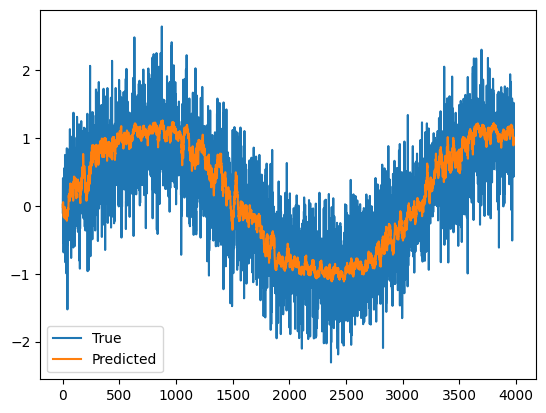

In [6]:
model.eval()
with torch.no_grad():
    preds = model(X).squeeze().numpy()
import matplotlib.pyplot as plt

plt.plot(series[seq_len:], label='True')
plt.plot(preds,    label='Predicted')
plt.legend(); plt.show()

## Metrics

In [9]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure your model and data are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X = X.to(device)
y = y.to(device)

# Switch model to evaluation mode and disable gradient computation
model.eval()
with torch.no_grad():
    # Generate predictions
    preds = model(X).squeeze().cpu().numpy()  # (batch,) array of predictions
    y_true = y.squeeze().cpu().numpy()        # (batch,) array of true values

# Compute accuracy metrics
mse = mean_squared_error(y_true, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)  # This is the accuracy score for regression

# Print results
print(f"Transformer Model Accuracy Metrics:")
print(f"  R² Score (Accuracy)      : {r2:.4f}")
print(f"  Mean Squared Error (MSE) : {mse:.4f}")
print(f"  Root MSE (RMSE)          : {rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")

Transformer Model Accuracy Metrics:
  R² Score (Accuracy)      : 0.6423
  Mean Squared Error (MSE) : 0.2663
  Root MSE (RMSE)          : 0.5160
  Mean Absolute Error (MAE): 0.4109


In [11]:
from sklearn.metrics import f1_score

# Direction encoding: 1 if increase, 0 otherwise
true_direction = (y_true[1:] > y_true[:-1]).astype(int)
pred_direction = (preds[1:] > y_true[:-1]).astype(int)

# Compute F1 Score on direction prediction
f1 = f1_score(true_direction, pred_direction, zero_division=1)
